In [1]:
import pyarrow.parquet as pq
import numpy as np
from scipy import sparse 
import os

import pandas as pd

In [2]:
filename_graph = '/home/vast/CGCS-GraphData.parquet'


In [3]:
column_source = 'Source'
column_source_location = 'SourceLocation'
column_type = 'eType'

columns = [column_source, column_source_location, column_type]

# Read only phone (eType = 1)

filters = [[(column_type, '=', 1)]]

df = pq.read_table(filename_graph, columns=columns, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df.shape[0]} nodes in channel 1')

df.drop(columns=['eType'], inplace=True)


70661593 nodes in channel 1


In [4]:
# all nodes have unique location

sl_uni = df.groupby('Source').SourceLocation.nunique()
(sl_uni!=1).sum()

0

In [5]:
# get node locations 

df_source_locations = df.groupby('Source').first()

# all nodes have a location

pd.isna(df_source_locations[['SourceLocation']]).sum()

SourceLocation    0
dtype: int64

In [6]:
df_source_locations

SourceLocation
Source                
456759               4
456760               1
456761               4
456762               4
456765               3
...                ...
657662               0
657664               0
657665               4
657666               2
657668               0

[100000 rows x 1 columns]

In [7]:
df_source_locations.to_parquet('NodeLocations.parquet')

In [8]:
df_source_locations.loc[456759].SourceLocation

4

In [9]:
c_source = 'Source'
c_target = 'Target'
c_time = 'Time'
c_weight = 'Weight'
c_type = 'eType'

columns = [c_source, c_target, c_time, c_weight, c_type]

# Read only sell (eType = 2)

filters = [[(c_type, '=', 2)]]

df_sell = pq.read_table(filename_graph, columns=columns, use_legacy_dataset=False, filters=filters).to_pandas()
df_sell.drop(columns=['eType'], inplace=True)

# Read only buy (eType = 3)

filters = [[(c_type, '=', 3)]]

df_buy = pq.read_table(filename_graph, columns=columns, use_legacy_dataset=False, filters=filters).to_pandas()
df_buy.drop(columns=['eType'], inplace=True)


In [10]:
df_sell.set_index([c_target, c_time, c_weight], inplace=True)
df_buy.set_index([c_target, c_time, c_weight], inplace=True)


In [11]:
(df_sell.index.duplicated()).sum()


184

In [12]:
(df_buy.index.duplicated()).sum()

184

In [13]:
df_sell_buy = pd.concat([df_sell[~df_sell.index.duplicated()], 
                    df_buy[~df_buy.index.duplicated()]], 
                   axis=1, sort=False)

In [14]:
df_sell_buy.reset_index(inplace=True)
df_sell_buy.columns=['Product', 'Time', 'Weight', 'Seller', 'Buyer']

In [15]:
df_sell_buy

Product      Time   Weight  Seller   Buyer
0        456806    902450     48.0  652219  505984
1        456806   2133620    215.0  534681  570191
2        456806   2282057    535.0  515106  470084
3        456806   2872821    683.0  612282  651234
4        456806   3491158    106.0  629490  624359
...         ...       ...      ...     ...     ...
389022   657321  20110845    557.0  520158  589057
389023   657321  24240973  25476.0  520158  587935
389024   657504  11422763    307.0  523554  643625
389025   657504  16456577    496.0  523554  578728
389026   657586   3583006    229.0  531594  646853

[389027 rows x 5 columns]

In [36]:
count_transactions =  df_sell_buy.groupby(['Seller', 'Buyer', 'Product'])[['Product']].count()
count_transactions.columns = ['Count']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8dfd8cb10>]],
      dtype=object)

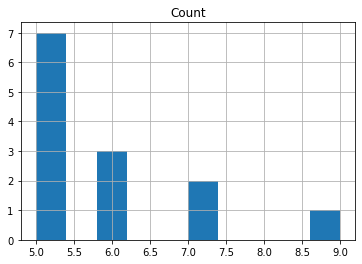

In [37]:
count_transactions[count_transactions.Count > 4].hist()

In [38]:
count_transactions_g5 = count_transactions[count_transactions.Count > 5]

In [39]:
count_transactions_g5

Count
Seller Buyer  Product       
497191 561428 499177       6
542649 572391 476813       6
550287 512397 657187       7
595104 570284 482264       9
620791 561428 466410       6
644830 585212 487668       7

In [40]:
count_transactions_g6 = count_transactions[count_transactions.Count > 6]

In [41]:
candidates_buyer_seller = count_transactions_g6.copy()
candidates_buyer_seller.reset_index()

Seller   Buyer  Product  Count
0  550287  512397   657187      7
1  595104  570284   482264      9
2  644830  585212   487668      7

In [42]:
candidates_buyer_seller.to_csv('candidates_buyer_seller_ids.csv')

In [21]:
count = 0

for ix, r in count_transactions_g6.iterrows():
    seller_id = ix[0]
    buyer_id = ix[1]
    loc_seller = df_source_locations.loc[seller_id].SourceLocation
    loc_buyer = df_source_locations.loc[buyer_id].SourceLocation
    if loc_seller != loc_buyer:
        count += 1
count

3

In [23]:
count_sell = sell_g_by_prod.size().to_frame('size').reset_index()
print(f'Products sold: {count_eq_prod_time.shape[0]}')

TypeError: 'numpy.int64' object is not callable

In [24]:
c_source = 'Source'
c_target = 'Target'
c_time = 'Time'
c_weight = 'Weight'
c_type = 'eType'

columns = [c_source, c_target, c_time, c_weight, c_type]

# Read only sell buy (eType = 2, 3)

filters = [[(c_type, '=', 2)], [(c_type, '=', 3)]]

df_sell_buy = pq.read_table(filename_graph, columns=columns, use_legacy_dataset=False, filters=filters).to_pandas()

In [25]:
groupped_time = df_sell_buy.groupby([c_target, c_time, c_weight])

count_eq_prod_time = groupped_time.size().to_frame('size').reset_index()
print(f'Products sold: {count_eq_prod_time.shape[0]}')

Products sold: 389027


In [375]:
columns=['Product', 'Time', 'Weight', 'Seller', 'Buyer']

df_sell_buy_d = pd.DataFrame(columns=columns)

# easy to disambiguate cases: 2210
for _, r in count_eq_prod_time[count_eq_prod_time['size']>=6].iterrows():
    gr = groupped_time.get_group((r.Target, r.Time, r.Weight))
    # there is only one seller, we can associate the seller to every buyer
    # 2186 cases
    if gr[gr.eType == 2].Source.nunique() == 1: 
        seller_id = gr[gr.eType == 2].iloc[0].Source
        for _, buyer_id in gr[gr.eType == 3].Source.items():
            df_sell_buy_d = df_sell_buy_d.append({
                'Product': r.Target, 
                'Time': r.Time,
                'Weight': r.Weight,
                'Seller': seller_id,
                'Buyer': buyer_id
            }, ignore_index=True)
            
    # there is only one buyer, we can associate the buyer to every seller, 
    # 24 other cases
    elif gr[gr.eType == 3].Source.nunique() == 1: 
        buyer_id = gr[gr.eType == 3].iloc[0].Source
        for _, seller_id in gr[gr.eType == 2].Source.items():
            df_sell_buy_d = df_sell_buy_d.append({
                'Product': r.Target, 
                'Time': r.Time,
                'Weight': r.Weight,
                'Seller': seller_id,
                'Buyer': buyer_id
            }, ignore_index=True)
            
   

In [382]:
count = 0

for _, r in count_eq_prod_time[count_eq_prod_time['size']>=4].iterrows():
    gr = groupped_time.get_group((r.Target, r.Time, r.Weight))            
    # there are different buyers/sellers, we associate all buyers to all sellers
    # 23 cases
    if gr[gr.eType == 2].Source.nunique() != 1 and gr[gr.eType == 3].Source.nunique() != 1: 
        count += 1
        for _, seller_id in gr[gr.eType == 2].Source.items():
            for _, buyer_id in gr[gr.eType == 3].Source.items():
                df_sell_buy_d = df_sell_buy_d.append({
                    'Product': r.Target, 
                    'Time': r.Time,
                    'Weight': r.Weight,
                    'Seller': seller_id,
                    'Buyer': buyer_id
                }, ignore_index=True)
count

23

In [384]:
cols = ['Product', 'Time', 'Seller', 'Buyer']
types = [np.int32, np.int32, np.int32, np.int32]
df_sell_buy_d.astype(dict(zip(cols, types)), copy=False)    

Product      Time  Weight  Seller   Buyer
0     457622  11341131     1.0  532126  586164
1     457622  11341131     1.0  532126  645277
2     462923   4068938     1.0  483619  620375
3     462923   4068938     1.0  483619  622324
4     466410   1828317     1.0  620791  546961
..       ...       ...     ...     ...     ...
412   605235  24025010     1.0  572119  532434
413   605235  26915685     1.0  522302  601891
414   605235  26915685     1.0  522302  642906
415   605235  26915685     1.0  601891  601891
416   605235  26915685     1.0  601891  642906

[417 rows x 5 columns]

In [397]:
df_all_seller_buyers = pd.concat([df_sell_buy_d, df_sell_buy])

cols = ['Product', 'Time', 'Seller', 'Buyer']
types = [np.int32, np.int32, np.int32, np.int32]
df_all_seller_buyers.astype(dict(zip(cols, types)), copy=False)    

Product      Time   Weight  Seller   Buyer
0        457622  11341131      1.0  532126  586164
1        457622  11341131      1.0  532126  645277
2        462923   4068938      1.0  483619  620375
3        462923   4068938      1.0  483619  622324
4        466410   1828317      1.0  620791  546961
...         ...       ...      ...     ...     ...
389022   657321  20110845    557.0  520158  589057
389023   657321  24240973  25476.0  520158  587935
389024   657504  11422763    307.0  523554  643625
389025   657504  16456577    496.0  523554  578728
389026   657586   3583006    229.0  531594  646853

[389444 rows x 5 columns]

In [407]:
groupped_seller_buyer = df_all_seller_buyers.groupby(['Seller', 'Buyer'])

count_transactions =  groupped_seller_buyer[['Product']].count()

In [405]:
count_transactions_g4 = count_transactions[count_transactions.Product > 3]

In [408]:
groupped_seller_buyer

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca32f3b510>]],
      dtype=object)

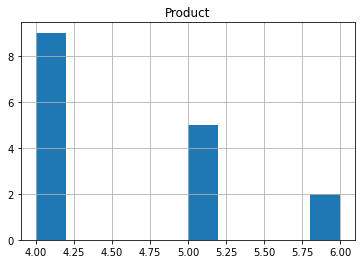

In [402]:
count_transactions_g4.hist()

In [401]:
count_transactions[count_transactions.Product > 5]

Product
Seller   Buyer    Weight         
497191.0 561428.0 1.0           6
620791.0 561428.0 1.0           6

In [409]:
# df_sell_buy_w_locations = pd.DataFrame(columns=['Seller', 'Buyer',  'SellerLocation', 'BuyerLocation', 'NTransactions'])

sell_buyer_array = []


count = 0

for ix, r in count_transactions[count_transactions.Product > 5].iterrows():
    seller_id = ix[0]
    buyer_id = ix[1]
    loc_seller = df_source_locations.loc[seller_id].SourceLocation
    loc_buyer = df_source_locations.loc[buyer_id].SourceLocation
    nt = r.Product
    display(groupped_seller_buyer.get_group((seller_id, buyer_id)))
#     df_sell_buy_w_locations = df_sell_buy_w_locations.append({
#         'Seller': seller_id,
#         'Buyer': buyer_id,
#         'SellerLocation': loc_seller,
#         'BuyerLocation': loc_buyer,
#         'NTransactions': nt
#     }, ignore_index=True)
    
#     if loc_seller != loc_buyer:
#         display(ix)
#         print(loc_seller, loc_buyer)
#         count += 1
# count

Product        Time  Weight    Seller     Buyer
96183  499177.0  12822542.0     1.0  497191.0  561428.0
96723  499177.0  15902650.0     1.0  497191.0  561428.0
97385  499177.0  19714373.0     1.0  497191.0  561428.0
98104  499177.0  23852429.0     1.0  497191.0  561428.0
98581  499177.0  26635433.0     1.0  497191.0  561428.0
98754  499177.0  27600022.0     1.0  497191.0  561428.0

Product        Time  Weight    Seller     Buyer
18564  464333.0   5484394.0   784.0  536600.0  573171.0
18618  464333.0  10736083.0   106.0  536600.0  573171.0
18692  464333.0  18150317.0   332.0  536600.0  573171.0
18763  464333.0  25752327.0   169.0  536600.0  573171.0
38191  474908.0  30017571.0   285.0  536600.0  573171.0
63794  484554.0  10204838.0    52.0  536600.0  573171.0

Product        Time  Weight    Seller     Buyer
41040  476813.0  10573552.0   398.0  542649.0  572391.0
41041  476813.0  11457714.0   123.0  542649.0  572391.0
41042  476813.0  12032171.0   171.0  542649.0  572391.0
41043  476813.0  12110938.0   364.0  542649.0  572391.0
41044  476813.0  13053223.0   110.0  542649.0  572391.0
41045  476813.0  15115449.0   150.0  542649.0  572391.0

Product        Time  Weight    Seller     Buyer
388691  657187.0  10250285.0   170.0  550287.0  512397.0
388693  657187.0  12459732.0   314.0  550287.0  512397.0
388696  657187.0  14490022.0   445.0  550287.0  512397.0
388697  657187.0  16267662.0   792.0  550287.0  512397.0
388698  657187.0  16758558.0   331.0  550287.0  512397.0
388699  657187.0  17614335.0   430.0  550287.0  512397.0
388700  657187.0  17671007.0   122.0  550287.0  512397.0

Product        Time  Weight    Seller     Buyer
71732   489532.0  30874357.0     5.0  561428.0  536600.0
140038  528403.0   4975230.0   253.0  561428.0  536600.0
140182  528403.0  25958245.0   325.0  561428.0  536600.0
200127  560915.0  18931703.0   757.0  561428.0  536600.0
223799  572774.0   6057020.0    10.0  561428.0  536600.0
296860  610792.0    959767.0  1006.0  561428.0  536600.0

Product        Time  Weight    Seller     Buyer
71239   489532.0   6057002.0   460.0  561428.0  561428.0
71454   489532.0  15952339.0    33.0  561428.0  561428.0
71503   489532.0  18466837.0    35.0  561428.0  561428.0
71522   489532.0  19440027.0   498.0  561428.0  561428.0
73396   490206.0  15812415.0   677.0  561428.0  561428.0
296877  610792.0   9382216.0    23.0  561428.0  561428.0

Product        Time  Weight    Seller     Buyer
46779  482264.0  10728949.0   298.0  595104.0  570284.0
46781  482264.0  12833338.0   109.0  595104.0  570284.0
46782  482264.0  12984768.0   116.0  595104.0  570284.0
46783  482264.0  14838769.0   319.0  595104.0  570284.0
46784  482264.0  15685418.0   623.0  595104.0  570284.0
46786  482264.0  16460993.0   333.0  595104.0  570284.0
46787  482264.0  16488049.0   648.0  595104.0  570284.0
46788  482264.0  18505321.0   759.0  595104.0  570284.0
46789  482264.0  20858864.0   334.0  595104.0  570284.0

Product        Time  Weight    Seller     Buyer
174342  550308.0  18175838.0    83.0  609316.0  570191.0
270717  596301.0   4708935.0    78.0  609316.0  570191.0
270841  596301.0   6331234.0    34.0  609316.0  570191.0
271505  596301.0  14702440.0   139.0  609316.0  570191.0
272542  596301.0  27845197.0    52.0  609316.0  570191.0
314610  623704.0  30295200.0   563.0  609316.0  570191.0

Product        Time  Weight    Seller     Buyer
20528  466410.0   1681926.0     1.0  620791.0  561428.0
20694  466410.0   5641222.0     1.0  620791.0  561428.0
20919  466410.0  11945058.0     1.0  620791.0  561428.0
21028  466410.0  14795826.0     1.0  620791.0  561428.0
21104  466410.0  16870627.0     1.0  620791.0  561428.0
21566  466410.0  29818808.0     1.0  620791.0  561428.0

Product        Time  Weight    Seller     Buyer
69631  487668.0  13302589.0   958.0  644830.0  585212.0
69633  487668.0  14314933.0   213.0  644830.0  585212.0
69635  487668.0  15936004.0   276.0  644830.0  585212.0
69636  487668.0  16227037.0   245.0  644830.0  585212.0
69637  487668.0  17764060.0   213.0  644830.0  585212.0
69638  487668.0  18425192.0   581.0  644830.0  585212.0
69640  487668.0  20170502.0   209.0  644830.0  585212.0

Product        Time  Weight    Seller     Buyer
216591  569215.0  11763945.0   211.0  647740.0  570191.0
217963  569215.0  23070495.0   561.0  647740.0  570191.0
349808  641131.0  10215831.0   500.0  647740.0  570191.0
350722  641131.0  12183351.0   144.0  647740.0  570191.0
353075  641131.0  17281238.0   107.0  647740.0  570191.0
355100  641131.0  21732513.0   680.0  647740.0  570191.0

In [457]:
df_bs = groupped_seller_buyer.get_group((595104, 570284)).copy()

cols = ['Product', 'Time', 'Seller', 'Buyer']
types = [np.int32, np.int32, np.int32, np.int32]
df_bs.astype(dict(zip(cols, types)), copy=False)    

Product      Time  Weight  Seller   Buyer
46779   482264  10728949   298.0  595104  570284
46781   482264  12833338   109.0  595104  570284
46782   482264  12984768   116.0  595104  570284
46783   482264  14838769   319.0  595104  570284
46784   482264  15685418   623.0  595104  570284
46786   482264  16460993   333.0  595104  570284
46787   482264  16488049   648.0  595104  570284
46788   482264  18505321   759.0  595104  570284
46789   482264  20858864   334.0  595104  570284

In [ ]:
df_bs

In [458]:
# def dateparse(self, time_in_secs):    
#     years = 2025-1970
#     d = datetime.fromtimestamp(float(time_in_secs))
#     return d.replace(year = d.year + years)
import datetime

# current date and time
origin = datetime.datetime(2025, 1, 1, 0, 0)

df_bs['Time'] = pd.to_datetime(df_bs['Time'], unit='s', origin=pd.to_datetime(origin)) 

In [464]:
cols = ['Product', 'Seller', 'Buyer', 'Weight']
types = [np.int32, np.int32, np.int32, np.int32]
df_bs.astype(dict(zip(cols, types)), copy=False)    

Product                Time  Weight  Seller   Buyer
46779   482264 2025-05-05 04:15:49     298  595104  570284
46781   482264 2025-05-29 12:48:58     109  595104  570284
46782   482264 2025-05-31 06:52:48     116  595104  570284
46783   482264 2025-06-21 17:52:49     319  595104  570284
46784   482264 2025-07-01 13:03:38     623  595104  570284
46786   482264 2025-07-10 12:29:53     333  595104  570284
46787   482264 2025-07-10 20:00:49     648  595104  570284
46788   482264 2025-08-03 04:22:01     759  595104  570284
46789   482264 2025-08-30 10:07:44     334  595104  570284

In [434]:
import altair as alt

In [463]:
base = alt.Chart(df_bs)

base = base.encode(
     x=alt.X('Time:T',scale=alt.Scale( domain=['2025-01-01', '2025-12-31'])), 
)

source = base.mark_circle(size=40, color='salmon').encode(
    y=alt.Y('Seller:N')
)
target = base.mark_circle(size=40, color='steelblue').encode(
    y=alt.Y('Buyer:N')
)
rule = base.mark_rule(color='gray').encode(
    y=alt.Y('Seller:N'),
    y2=alt.Y2('Buyer:N')
)

chart = alt.layer(
        rule,
        target,
        source,
).properties(
    width=900,
    height={'step': 11},
)

chart

alt.LayerChart(...)